# Detection project (2 сценарий)

## 1). Выбор фреймворка/библиотеки для использования детектора

Для выполнения задачи детекции я выбрал API `detectron2`

In [3]:
!pip install -U Catalyst

     |████████████████████████████████| 491kB 11.1MB/s 
     |████████████████████████████████| 317kB 20.4MB/s 


## 2). Запуск детектора на случайных изображениях


In [1]:
import torch, torchvision
from torchvision.transforms import transforms
from torch.optim import optimizer
 
import numpy as np
import os, shutil
from PIL import Image, ImageDraw
from copy import deepcopy
import matplotlib.pyplot as plt
 
from torch.utils.data import DataLoader, Dataset
from skimage import transform

Добавим картинки для теста готовой модели

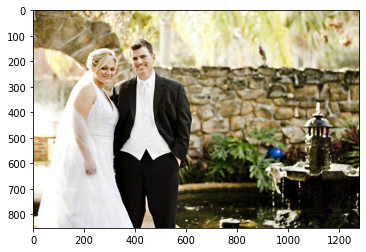

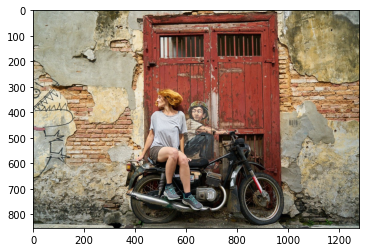

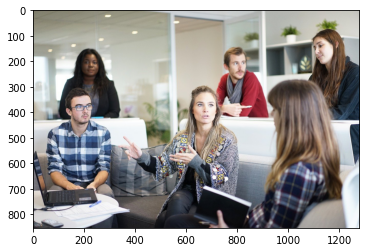

In [2]:
!wget https://cdn.pixabay.com/photo/2014/09/23/21/01/newlyweds-458119_1280.jpg -q -O input1.jpg
!wget https://cdn.pixabay.com/photo/2017/12/28/17/10/motorcycles-3045706_1280.jpg -q -O input2.jpg
!wget https://cdn.pixabay.com/photo/2016/03/09/09/22/workplace-1245776_1280.jpg -q -O input3.jpg

im = [Image.open("./input1.jpg").convert("RGB"), Image.open("./input2.jpg").convert("RGB"), Image.open("./input3.jpg").convert("RGB")]
for i in im:
    plt.figure()
    plt.imshow(i)

Загрузим модель `faster_rcnn` для датасета COCO

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
frpil = transforms.ToTensor()
pred = model([frpil(i) for i in im])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


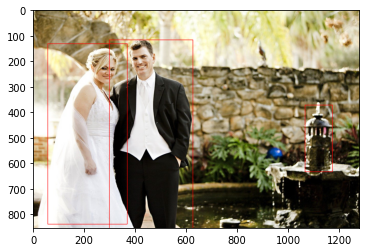

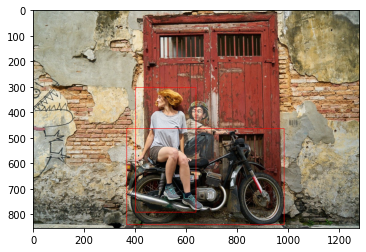

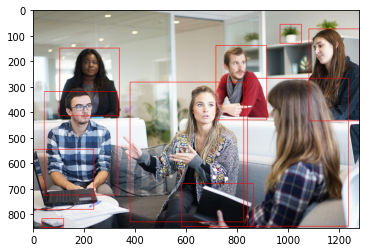

In [5]:
def draw_empty_rect(do, xy):
    do.line((xy[0], xy[1], xy[2], xy[1]), fill='red', width=2)
    do.line((xy[2], xy[1], xy[2], xy[3]), fill='red', width=2)
    do.line((xy[0], xy[3], xy[2], xy[3]), fill='red', width=2)
    do.line((xy[0], xy[1], xy[0], xy[3]), fill='red', width=2)
    

for i in range(3):
    plt.figure()
    draw = ImageDraw.Draw(im[i])
    for k in range(len(pred[i]['boxes'])):
        if pred[i]['scores'][k] >= 0.9:
            box = pred[i]['boxes'][k]
            draw_empty_rect(draw, box)
    plt.imshow(im[i])

Модель на данных примерах(я не нашёл удобных библиотек для визуализации) выделяла следующие классы: Человек, Книга, Ноутбук, горшок с цветком, Мотоцикл, Фонтан(?), Пульт.

## 3). Выбор датасета

Датасетом я выбрал Wider Face

In [6]:
%%bash
 
download-gdrive 0B6eKvaijfFUDQUUwd21EckhUbWs wider_train.zip
extract-archive wider_train.zip &>/dev/null
download-gdrive 0B6eKvaijfFUDd3dIRmpvSk8tLUk wider_valid.zip
extract-archive wider_valid.zip &>/dev/null

--2021-02-14 18:04:59--  https://docs.google.com/uc?export=download&confirm=wAJh&id=0B6eKvaijfFUDQUUwd21EckhUbWs
Resolving docs.google.com (docs.google.com)... 74.125.20.113, 74.125.20.100, 74.125.20.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-2k-docs.googleusercontent.com/docs/securesc/djo2jntubssbvba4r9ls78od0h77ak4b/vibndtb4tgeo6jkqpp3cto2ob75if6qv/1613325825000/13356917703944334611/09865745195359628759Z/0B6eKvaijfFUDQUUwd21EckhUbWs?e=download [following]
--2021-02-14 18:04:59--  https://doc-0o-2k-docs.googleusercontent.com/docs/securesc/djo2jntubssbvba4r9ls78od0h77ak4b/vibndtb4tgeo6jkqpp3cto2ob75if6qv/1613325825000/13356917703944334611/09865745195359628759Z/0B6eKvaijfFUDQUUwd21EckhUbWs?e=download
Resolving doc-0o-2k-docs.googleusercontent.com (doc-0o-2k-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-0o-2k-docs.g

In [7]:
!wget http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
!unzip wider_face_split.zip > /dev/null
!rm wider_face_split.zip
!rm wider_train.zip
!rm wider_valid.zip

--2021-02-14 18:05:45--  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3591642 (3.4M) [application/zip]
Saving to: ‘wider_face_split.zip’

wider_face_split.zi 100%[===================>]   3.42M  3.15MB/s    in 1.1s    

2021-02-14 18:05:46 (3.15 MB/s) - ‘wider_face_split.zip’ saved [3591642/3591642]



In [8]:
shutil.copy("./wider_face_split/wider_face_train_bbx_gt.txt", "./WIDER_train/wider_face_train_bbx_gt.txt")
shutil.copy("./wider_face_split/wider_face_val_bbx_gt.txt", "./WIDER_val/wider_face_val_bbx_gt.txt")

'./WIDER_val/wider_face_val_bbx_gt.txt'

## 4). Предобработка данных

Для детекции наш датасет будет возвращать словарь с картинкой, боксами и классами(в нашем случае он один). Стоит заметить что формат входных данных xywh, а формат данных для модели хуху.

In [18]:
"""
Класс нашего датасета
"""
class WiderFaceDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        with open(txt_file) as f:
            lines = f.readlines()
            self.dataset = []
            for ind, line in enumerate(lines):
                if line.rstrip().endswith('.jpg'):
                    self.dataset.append({'file_name': line.rstrip(),
                                         'boxes': []})
                elif len(line.split()) != 1:
                    inp = line.split()
                    self.dataset[-1]['boxes'].append(np.array([float(inp[0]), 
                                                               float(inp[1]),
                                                               float(inp[0]) + float(inp[2]),
                                                               float(inp[1]) + float(inp[3])]))
        self.dataset = self.dataset[:50] # не хочу чтобы модель 20 дней училась, и 50 картинками обойдётся
        self.root_dir = root_dir
        self.transform = transform
 
    def __len__(self):
        return len(self.dataset)
 
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.dataset[idx]['file_name'])
        image = Image.open(img_name).convert('RGB')
        sample = {'image': image, 
                  'boxes': torch.tensor(self.dataset[idx]['boxes'])}

        if self.transform:
            sample = self.transform(sample)
 
        return sample


"""
Наш загрузчик Датасета по батчам
"""
class MyDataLoader(object):
    def __init__(self, ds, batch_size):
        self.dataset = ds
        self.batch_size = batch_size
        self.perm = np.random.permutation(len(ds))
        self.batch_num =  len(ds) // batch_size

    def __iter__(self):
        for i in range(0, len(self.dataset), self.batch_size):
            features = []
            labels = []
            if i + self.batch_size >= len(self.dataset):
                break
            for k in range(i, i + self.batch_size):
                features.append(self.dataset[self.perm[k]]['image'])
                labels.append({'boxes': self.dataset[self.perm[k]]['boxes'],
                               'labels': torch.ones(len(self.dataset[self.perm[k]]['boxes'])).type(torch.int64)
                               'image_id': torch.tensor([perm[k]])})
            print('iter_passed')
            yield [features, labels]
    
    def __len__(self):
        return self.batch_num

SyntaxError: ignored

In [4]:
class MyToTensor(object):
    def __call__(self, sample):
        tf = transforms.ToTensor()
        sample['image'] = tf(sample['image'])
        return sample


class MyResize(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        self.resize = transforms.Resize(output_size)

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']

        h, w = image.shape[1:]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = self.resize(image)
        for i in range(len(boxes)):
            boxes[i] = torch.tensor([boxes[i][0] * new_w / w, 
                                     boxes[i][1] * new_h / h,
                                     boxes[i][2] * new_w / w + 1, 
                                     boxes[i][3] * new_h / h + 1])

        return {'image': img, 'boxes': boxes}


class MyNormalize(object):
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean=mean, std=std)
    
    def __call__(self, sample):
        img, boxes = sample['image'], sample['boxes']
        img = self.normalize(img)
        return {'image': img, 'boxes': boxes}

In [10]:
train_set = WiderFaceDataset('WIDER_train/wider_face_train_bbx_gt.txt', 
                             'WIDER_train/images', 
                             transform=transforms.Compose([MyToTensor(),
                                                           MyResize((1024, 1024)),
                                                           MyNormalize(mean=[0.485, 0.456, 0.406],
                                                                       std=[0.229, 0.224, 0.225])]))
val_set = WiderFaceDataset('WIDER_val/wider_face_val_bbx_gt.txt', 
                           'WIDER_val/images', 
                           transform=transforms.Compose([MyToTensor(),
                                                         MyResize((1024, 1024)),
                                                         MyNormalize(mean=[0.485, 0.456, 0.406],
                                                                     std=[0.229, 0.224, 0.225])]))

Тут пожалуй и реализуем показ картинок

In [5]:
def draw_empty_rect(do, xy):
    do.line((xy[0], xy[1], xy[2], xy[1]), fill='red', width=2)
    do.line((xy[2], xy[1], xy[2], xy[3]), fill='red', width=2)
    do.line((xy[0], xy[3], xy[2], xy[3]), fill='red', width=2)
    do.line((xy[0], xy[1], xy[0], xy[3]), fill='red', width=2)

In [6]:
def show_img(image, boxes):
    tf = transforms.ToPILImage()
    img = tf(deepcopy(image))
    for i in boxes:
        draw = ImageDraw.Draw(img)
        draw_empty_rect(draw, i)
    plt.figure()
    plt.imshow(img)

In [7]:
sample = train_set[12]
show_img(**sample)

NameError: ignored

## 5). Обучение модели-детектора

Подсмотрели одну вещь из туториала пайторча и скачали.

In [9]:
!git clone https://github.com/pytorch/vision.git
shutil.copy("./vision/references/detection/engine.py", "./engine.py")
shutil.copy("./vision/references/detection/coco_utils.py", "./coco_utils.py")
shutil.copy("./vision/references/detection/coco_eval.py", "./coco_eval.py")
shutil.copy("./vision/references/detection/utils.py", "./utils.py")
shutil.copy("./vision/references/detection/transforms.py", "./transforms.py")

Cloning into 'vision'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 15224 (delta 213), reused 193 (delta 142), pack-reused 14938
Receiving objects: 100% (15224/15224), 16.05 MiB | 13.63 MiB/s, done.
Resolving deltas: 100% (10795/10795), done.


'./transforms.py'

In [8]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
from engine import train_one_epoch, evaluate
import utils


train_loader = MyDataLoader(train_set, 5)
val_loader = MyDataLoader(val_set, 1)
device = torch.device('cpu')
num_classes = 2
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

num_epochs = 10
epochs_models = []
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=1)
    epochs_models.append(model)
    lr_scheduler.step()
    evaluate(model, val_loader, device=device)

iter_passed
Epoch: [0]  [ 0/10]  eta: 0:14:30  lr: 0.000034  loss: 1.3686 (1.3686)  loss_classifier: 0.3313 (0.3313)  loss_box_reg: 0.2960 (0.2960)  loss_objectness: 0.3848 (0.3848)  loss_rpn_box_reg: 0.3564 (0.3564)  time: 87.0190  data: 0.7162
iter_passed
Epoch: [0]  [ 1/10]  eta: 0:12:53  lr: 0.000067  loss: 1.0370 (1.2028)  loss_classifier: 0.2464 (0.2889)  loss_box_reg: 0.2960 (0.3050)  loss_objectness: 0.2392 (0.3120)  loss_rpn_box_reg: 0.2374 (0.2969)  time: 85.9057  data: 0.7106
iter_passed
Epoch: [0]  [ 2/10]  eta: 0:11:22  lr: 0.000100  loss: 1.1846 (1.1967)  loss_classifier: 0.2977 (0.2918)  loss_box_reg: 0.3140 (0.3479)  loss_objectness: 0.2392 (0.2820)  loss_rpn_box_reg: 0.2374 (0.2750)  time: 85.3222  data: 0.7222
iter_passed
Epoch: [0]  [ 3/10]  eta: 0:10:10  lr: 0.000133  loss: 1.0370 (1.1377)  loss_classifier: 0.2945 (0.2925)  loss_box_reg: 0.3002 (0.3360)  loss_objectness: 0.2219 (0.2527)  loss_rpn_box_reg: 0.2312 (0.2565)  time: 87.2074  data: 0.7350
iter_passed


In [ ]:
pred = model([transforms.ToTensor(im[2])])
show_img(im[2], pred[0]['boxes'])

In [30]:
%tensorboard --logdir {logdir}

UsageError: Line magic function `%tensorboard` not found.


## 6). Измерение качества работы модели

RuntimeError: ignored

## 7). Поиск путей применения этой модели в бизнесе/реальных задачах/набросок встраивания в веб/мобильное демо